In [1]:
import sys
sys.path.insert(0, "../")

import fairlearn.grid_search.binary_protected_attribute.binary_classification as bc

import numpy as np
import pandas as pd

from test import simple_learners

In [2]:
def simple_threshold_data(number_a0, number_a1,
                          a0_threshold, a1_threshold,
                          a0_label, a1_label):

    a0s = np.full(number_a0, a0_label)
    a1s = np.full(number_a1, a1_label)

    a0_scores = np.linspace(0, 1, number_a0)
    a1_scores = np.linspace(0, 1, number_a1)
    score_feature = np.concatenate((a0_scores, a1_scores), axis=None)

    A = np.concatenate((a0s, a1s), axis=None)

    Y_a0 = [x > a0_threshold for x in a0_scores]
    Y_a1 = [x > a1_threshold for x in a1_scores]

    Y = np.concatenate((Y_a0, Y_a1), axis=None)

    X = pd.DataFrame({"actual_feature": score_feature,
                      "protected_attribute_feature": A,
                      "constant_ones_feature": np.ones(len(Y))})
    return X, Y, A

In [4]:
num_samples_a0 = 30
num_samples_a1 = 40

a0_threshold= 0.4
a1_threshold = 0.

a0_label = 45
a1_label = 18

X, Y, A = simple_threshold_data(num_samples_a0, num_samples_a1, a0_threshold, a1_threshold, a0_label, a1_label)

In [5]:
import matplotlib.pyplot as plt

In [6]:
mask_a0 = X["protected_attribute_feature"] == a0_label
mask_a1 = X["protected_attribute_feature"] == a1_label

In [7]:
X_a0 = X[mask_a0]
Y_a0 = Y[mask_a0]
X_a1 = X[mask_a1]
Y_a1 = Y[mask_a1]

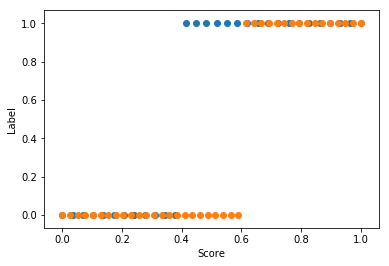

In [8]:
plt.scatter(X_a0["actual_feature"], Y_a0, label='a0')
plt.scatter(X_a1["actual_feature"], Y_a1, label='a1')
plt.xlabel("Score")
plt.ylabel("Label")
plt.show()

In [15]:
unfair_model = simple_learners.LeastSquaresBinaryClassifierLearner()
unfair_model.fit(X, Y, sample_weight=np.ones(len(Y)))

unfair_model.weights

actual_feature                 1.399976
constant_ones_feature         -0.433321
protected_attribute_feature    0.007407
dtype: float64

In [16]:
Y_predict = unfair_model.predict(X)

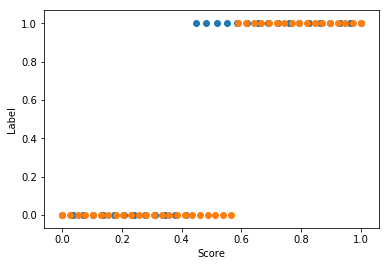

In [18]:
plt.scatter(X_a0["actual_feature"], Y_predict[mask_a0], label='a0')
plt.scatter(X_a1["actual_feature"], Y_predict[mask_a1], label='a1')
plt.xlabel("Score")
plt.ylabel("Label")
plt.show()

In [21]:
first_sweep = bc.sweep_demographic_parity(simple_learners.LeastSquaresBinaryClassifierLearner(),
            X, Y, A)

In [35]:
lagrange_multipliers = [x["lagrange_multiplier"] for x in first_sweep]
lagrange_multipliers

[-2.6666666666666665,
 -2.1333333333333333,
 -1.5999999999999999,
 -1.0666666666666664,
 -0.5333333333333332,
 0.0,
 0.5333333333333337,
 1.0666666666666669,
 1.6,
 2.1333333333333333,
 2.6666666666666665]

In [30]:
first_sweep_protected_attribute_weights = [
            x["model"].weights["protected_attribute_feature"] for x in first_sweep]


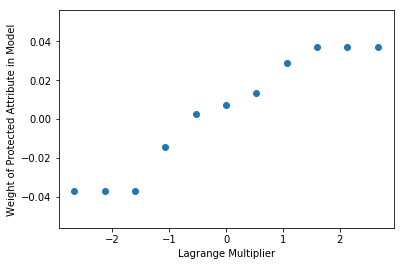

In [31]:
plt.scatter(lagrange_multipliers, first_sweep_protected_attribute_weights)
plt.xlabel("Lagrange Multiplier")
plt.ylabel("Weight of Protected Attribute in Model")
plt.show()

In [32]:
best_model_first_sweep = first_sweep[4]["model"]

In [33]:
Y_first_predict = best_model_first_sweep.predict(X)

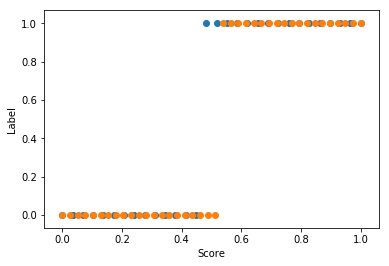

In [34]:
plt.scatter(X_a0["actual_feature"], Y_first_predict[mask_a0], label='a0')
plt.scatter(X_a1["actual_feature"], Y_first_predict[mask_a1], label='a1')
plt.xlabel("Score")
plt.ylabel("Label")
plt.show()

In [38]:
second_sweep_multipliers = np.linspace(first_sweep[3]["lagrange_multiplier"],
                                      first_sweep[4]["lagrange_multiplier"],
                                      11)
second_sweep = bc.sweep_demographic_parity(simple_learners.LeastSquaresBinaryClassifierLearner(),
            X, Y, A, lagrange_multipliers=second_sweep_multipliers, number_lagrange_multipliers=None)

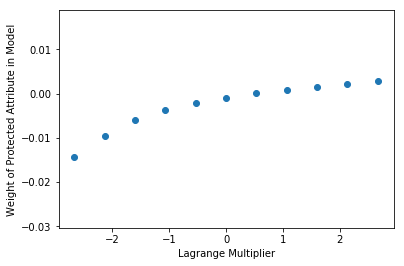

In [39]:
second_sweep_protected_attribute_weights = [
            x["model"].weights["protected_attribute_feature"] for x in second_sweep]
second_sweep_lagrange_multipliers = [x["lagrange_multiplier"] for x in second_sweep]
plt.scatter(lagrange_multipliers, second_sweep_protected_attribute_weights)
plt.xlabel("Lagrange Multiplier")
plt.ylabel("Weight of Protected Attribute in Model")
plt.show()

In [40]:
second_sweep_protected_attribute_weights

[-0.014287963408571025,
 -0.009483093722614078,
 -0.0059244176441616905,
 -0.003751782106581343,
 -0.0021645984593035017,
 -0.0009371906322294676,
 5.465667371973293e-05,
 0.0008850800223426103,
 0.0016011806048571997,
 0.002234430554754363,
 0.0028067683766365703]

In [41]:
best_model_second_sweep = second_sweep[6]["model"]

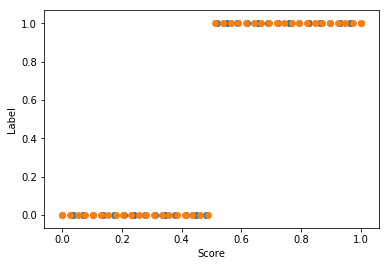

In [43]:
Y_second_predict = best_model_second_sweep.predict(X)
plt.scatter(X_a0["actual_feature"], Y_second_predict[mask_a0], label='a0')
plt.scatter(X_a1["actual_feature"], Y_second_predict[mask_a1], label='a1')
plt.xlabel("Score")
plt.ylabel("Label")
plt.show()